In [1]:
import csv
import math
import os, os.path
import io
import sys
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

%matplotlib inline

In [2]:
# Sample Decision Tree Classifier
from sklearn import datasets
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()

### Okay, so, time to work out which method is gonna be the best to use for our data

In [3]:
dataset = pd.read_csv("./Data/exoplanetarchive/candidates-20190613-TIDIED.csv", header = 24)
original_headers = list(dataset.columns.values)
original_headers

['kepid',
 'kepoi_name',
 'koi_period',
 'koi_period_err1',
 'koi_prad',
 'koi_prad_err1',
 'koi_teq',
 'koi_insol',
 'koi_insol_err1',
 'koi_steff',
 'koi_steff_err1',
 'koi_slogg',
 'koi_slogg_err1',
 'koi_srad',
 'koi_srad_err1']

In [4]:
# COLUMN kepid:              KepID
# COLUMN kepoi_name:         KOI Name
# COLUMN koi_period:         Orbital Period [days]
# COLUMN koi_period_err1:    Orbital Period Upper Unc. [days]
# COLUMN koi_prad:           Planetary Radius [Earth radii]
# COLUMN koi_prad_err1:      Planetary Radius Upper Unc. [Earth radii]
# COLUMN koi_teq:            Equilibrium Temperature [K]
# COLUMN koi_insol:          Insolation Flux [Earth flux]
# COLUMN koi_insol_err1:     Insolation Flux Upper Unc. [Earth flux]
# COLUMN koi_steff:          Stellar Effective Temperature [K]
# COLUMN koi_steff_err1:     Stellar Effective Temperature Upper Unc. [K]
# COLUMN koi_slogg:          Stellar Surface Gravity [log10(cm/s**2)]
# COLUMN koi_slogg_err1:     Stellar Surface Gravity Upper Unc. [log10(cm/s**2)]
# COLUMN koi_srad:           Stellar Radius [Solar radii]
# COLUMN koi_srad_err1:      Stellar Radius Upper Unc. [Solar radii]

In [5]:
dataset.head()

,kepid,kepoi_name,koi_period,koi_period_err1,koi_prad,koi_prad_err1,koi_teq,koi_insol,koi_insol_err1,koi_steff,koi_steff_err1,koi_slogg,koi_slogg_err1,koi_srad,koi_srad_err1
0,1025986,K07621.01,275.073650,0.039280,1.86,0.33,303.0,2.00,0.92,5604.0,84.0,4.226,0.208,1.187,0.207
1,1026957,K00958.01,21.761298,0.000017,2.53,0.16,486.0,13.18,3.00,4859.0,97.0,4.612,0.015,0.720,0.047
2,1161345,K00984.01,4.287467,0.000015,2.29,0.22,942.0,186.31,56.73,5296.0,105.0,4.576,0.015,0.815,0.080
3,1164301,K04921.01,95.688682,0.003599,28.41,1.13,1046.0,283.07,37.83,5040.0,60.0,2.681,0.029,13.056,0.520
4,1293379,K06253.01,27.556452,0.002928,1.40,0.54,531.0,18.86,22.40,5509.0,184.0,4.565,0.024,0.836,0.322


In [6]:
goldilocks_dataset = dataset.drop(['kepid',
                                   'koi_period',
                                   'koi_period_err1',
                                   'koi_prad_err1',
                                   #'koi_insol',
                                   'koi_insol_err1', 
                                   'koi_steff',
                                   'koi_steff_err1',
                                   'koi_slogg',
                                   'koi_slogg_err1',
                                   #'koi_srad',
                                   'koi_srad_err1'],
                                  axis=1).copy()
goldilocks_dataset.head()

,kepoi_name,koi_prad,koi_teq,koi_insol,koi_srad
0,K07621.01,1.86,303.0,2.00,1.187
1,K00958.01,2.53,486.0,13.18,0.720
2,K00984.01,2.29,942.0,186.31,0.815
3,K04921.01,28.41,1046.0,283.07,13.056
4,K06253.01,1.40,531.0,18.86,0.836


In [7]:
easy_ds = dataset.drop(['kepid',
                        #'kepoi_name',
                        'koi_period',
                        'koi_period_err1',
                        'koi_prad',
                        'koi_prad_err1',
                        #'koi_teq',
                        #'koi_insol',
                        'koi_insol_err1',
                        #'koi_steff',
                        'koi_steff_err1',
                        'koi_slogg',
                        'koi_slogg_err1',
                        'koi_srad',
                        'koi_srad_err1'
                        ], axis=1).dropna().copy()

easyX = easy_ds.drop("kepoi_name", axis=1)
#easyX.columns=['Equilibrium Temp (K)','Insolation Flux (f_E)','Stellar Temp (K)']
easyY = easy_ds["kepoi_name"]

easy_ds.head()

,kepoi_name,koi_teq,koi_insol,koi_steff
0,K07621.01,303.0,2.00,5604.0
1,K00958.01,486.0,13.18,4859.0
2,K00984.01,942.0,186.31,5296.0
3,K04921.01,1046.0,283.07,5040.0
4,K06253.01,531.0,18.86,5509.0


In [8]:
def goldilocks_temp(t):
    if t < 273:
        return "Too cold";
    elif t > 373:
        return "Too hot";
    else:
        return "Just right"

In [9]:
easy_ds.insert(3,"gold_temp",[(goldilocks_temp(t)) for t in easy_ds["koi_teq"]],True)

In [10]:
easy_ds.tail()

,kepoi_name,koi_teq,koi_insol,gold_temp,koi_steff
2313,K04303.01,327.0,2.72,Just right,5566.0
2314,K05979.01,592.0,29.06,Too hot,6178.0
2315,K04245.01,788.0,91.32,Too hot,6059.0
2316,K00298.02,397.0,5.85,Too hot,5250.0
2317,K02184.02,288.0,1.63,Just right,4620.0


In [11]:
easyX.head()

,koi_teq,koi_insol,koi_steff
0,303.0,2.00,5604.0
1,486.0,13.18,4859.0
2,942.0,186.31,5296.0
3,1046.0,283.07,5040.0
4,531.0,18.86,5509.0


In [12]:
new_data = goldilocks_dataset.dropna().copy()
X_gold = new_data.dropna().drop("kepoi_name", axis=1)
Y_gold = new_data['kepoi_name']

In [13]:
X_gold.tail()

,koi_prad,koi_teq,koi_insol,koi_srad
2313,3.32,327.0,2.72,1.170
2314,0.89,592.0,29.06,1.076
2315,1.76,788.0,91.32,1.554
2316,1.62,397.0,5.85,0.790
2317,2.17,288.0,1.63,0.736


In [14]:
Y_gold.shape

(2315,)

In [15]:
X_gold.columns=['Radius (r_E)','Equilibrium Temp (K)','Insolation Flux (f_E)','Solar Radius (r_Sol)']
X_gold.head()

,Radius (r_E),Equilibrium Temp (K),Insolation Flux (f_E),Solar Radius (r_Sol)
0,1.86,303.0,2.00,1.187
1,2.53,486.0,13.18,0.720
2,2.29,942.0,186.31,0.815
3,28.41,1046.0,283.07,13.056
4,1.40,531.0,18.86,0.836


In [16]:
Y_gold.head()

0    K07621.01
1    K00958.01
2    K00984.01
3    K04921.01
4    K06253.01
Name: kepoi_name, dtype: object

In [17]:
easyX.insert(3,"gold_temp",[(goldilocks_temp(t)) for t in easyX["koi_teq"]],True)
easyY = easyX["gold_temp"].copy()
easyX.head()

,koi_teq,koi_insol,koi_steff,gold_temp
0,303.0,2.00,5604.0,Just right
1,486.0,13.18,4859.0,Too hot
2,942.0,186.31,5296.0,Too hot
3,1046.0,283.07,5040.0,Too hot
4,531.0,18.86,5509.0,Too hot


In [18]:
easyX = easyX.drop("gold_temp", axis=1).copy()
easyX.head()

,koi_teq,koi_insol,koi_steff
0,303.0,2.00,5604.0
1,486.0,13.18,4859.0
2,942.0,186.31,5296.0
3,1046.0,283.07,5040.0
4,531.0,18.86,5509.0


In [19]:
from sklearn.decomposition import PCA  # 1. Choose the model class
model = PCA(n_components=2)            # 2. Instantiate the model with hyperparameters
model.fit(easyX)                       # 3. Fit to data. Notice y is not specified!
X_2D = model.transform(easyX)          # 4. Transform the data to two dimensions

In [20]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(easyX, easyY, random_state=1)

In [21]:
from sklearn.naive_bayes import GaussianNB # 1. choose model class
model = GaussianNB()                       # 2. instantiate model
model.fit(Xtrain, ytrain)                  # 3. fit model to data
y_model = model.predict(Xtest)             # 4. predict on new data

In [22]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, y_model)

# THIS GIVES ME THE ACCURACY SCORE OF THE ALGORITHM

0.9827288428324698

###### 98.3% Accuracy is pretty damn good!

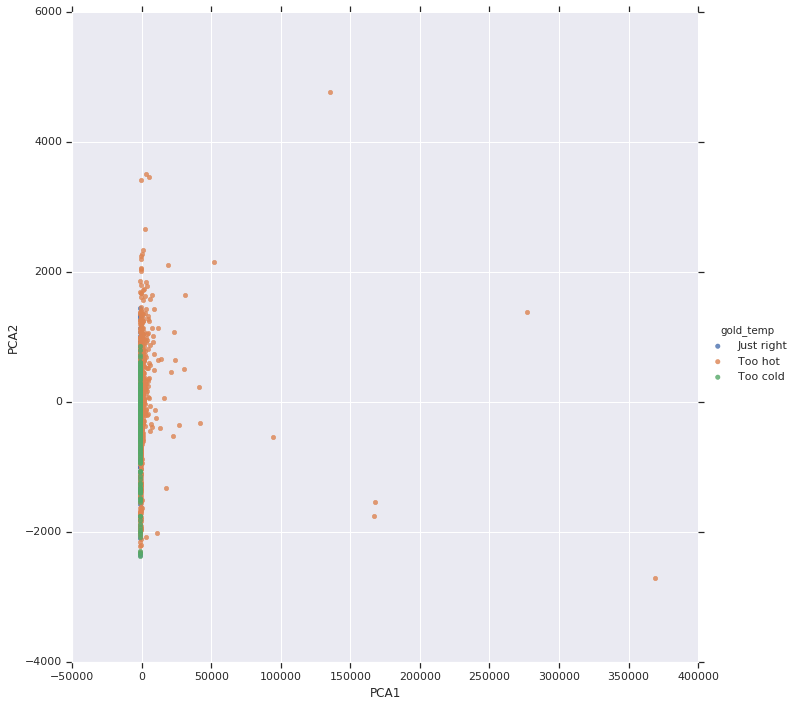

In [24]:
easy_ds['PCA1'] = X_2D[:, 0]
easy_ds['PCA2'] = X_2D[:, 1]
sb.set()
sb.lmplot("PCA1", "PCA2", hue='gold_temp', data=easy_ds, fit_reg=False,height=10);

###### Let's make a Dataset where I only take every 50 lines to narrow it down

In [25]:
easy2 = easy_ds[::50].drop(['PCA1','PCA2'],axis=1)
easy2X = easyX[::50]
easy2Y = easyY[::50]

In [27]:
model = PCA(n_components=2)            # 2. Instantiate the model with hyperparameters
model.fit(easy2X)                       # 3. Fit to data. Notice y is not specified!
X2_2D = model.transform(easy2X)          # 4. Transform the data to two dimensions
X2train, X2test, y2train, y2test = train_test_split(easy2X, easy2Y, random_state=1)
model = GaussianNB()                       # 2. instantiate model
model.fit(X2train, y2train)                  # 3. fit model to data
y2_model = model.predict(X2test)             # 4. predict on new data
accuracy_score(y2test, y2_model)

# THIS GIVES ME THE ACCURACY SCORE OF THE ALGORITHM

0.9166666666666666

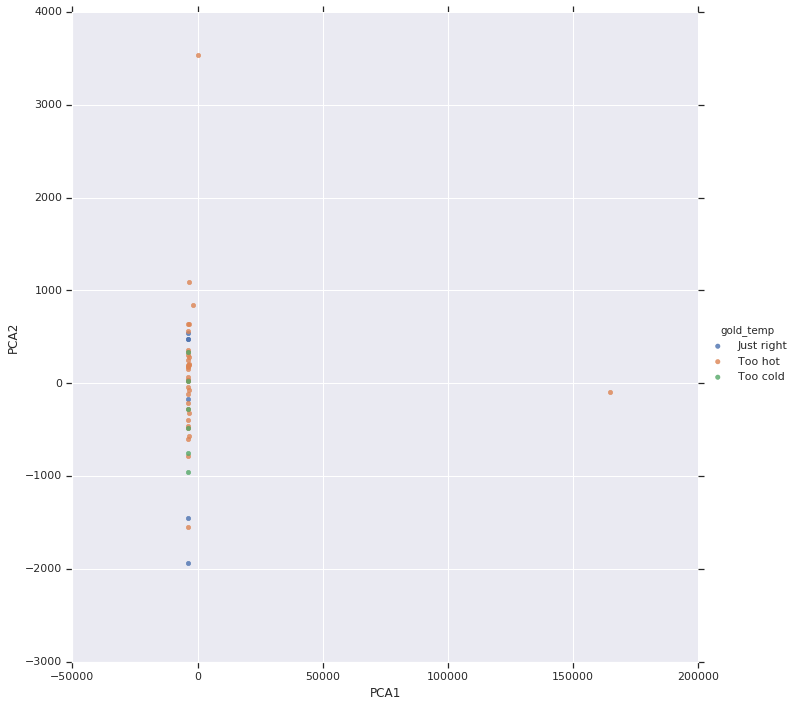

In [28]:
easy2['PCA1'] = X2_2D[:, 0]
easy2['PCA2'] = X2_2D[:, 1]
G1 = sb.lmplot("PCA1", "PCA2", hue='gold_temp', data=easy2, fit_reg=False, height=10);
#G1.set(ylim=(-2000, 1000), xlim=(-4000,-3000))

###### The outliers at the right and top really skews the graph... Let's try to reshape our graph to view the rest better!

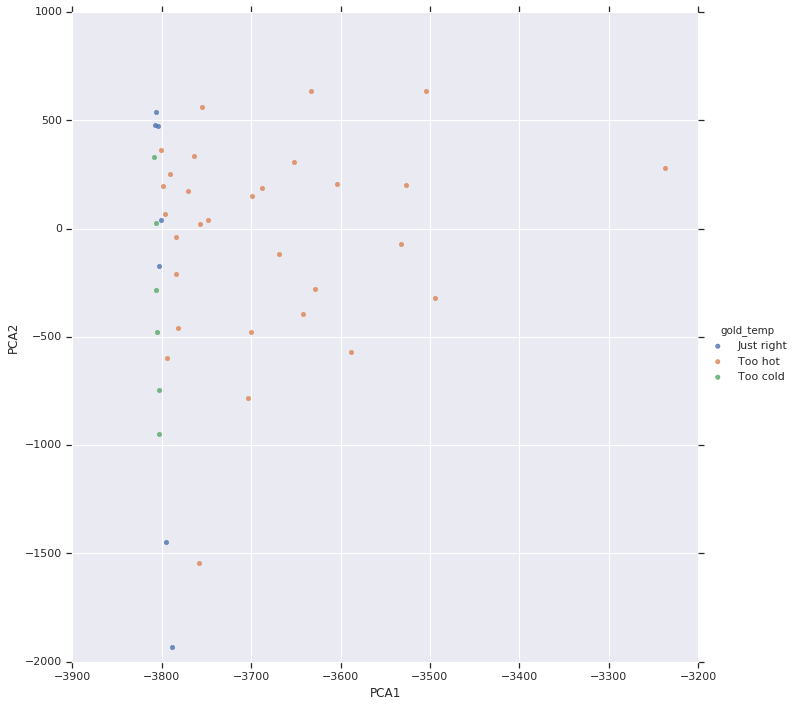

In [29]:
newG = sb.lmplot("PCA1", "PCA2", hue='gold_temp', data=easy2, fit_reg=False, height=10);
newG.set(ylim=(-2000, 1000), xlim=(-3900,-3200))

##### Seems to me like there's an essentially vertical line where the "Goldilocks zone" exists, and to the LEFT is too COLD and to the RIGHT is too HOT